# *LR decresing wrt epoch (inverse relationship) with random fluctutions *


---



---



*Save and Load results from here*

In [ ]:
def record_Results(key,results):
  import json
  from google.colab import drive


  drive.mount('/content/drive')

  dictionary ={
      key : results
  } 
  json_object = json.dumps(dictionary)

  FILE_PATH = "/content/drive/My Drive/Results/"+"CIFAR10_Experiment_3_0"+str(key)+".json"
  f = open(FILE_PATH, "w")
  f.write(json_object)
  print("recorded")

def Get_Results(file):
  import json
  from google.colab import drive

  drive.mount('/content/drive')

  FILE_PATH = "/content/drive/My Drive/Results/"+"CIFAR10_Experiment_3_0"+str(file)+".json"
  f = open(FILE_PATH, "r")
  json_object = json.load(f)
  
  return json_object

**STARTING GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.623139642000069
GPU (s):
0.04716409399998156
GPU speedup over CPU: 76x


In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

baseMapNum = 32
weight_decay = 1e-4

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
def cifar10_model():
  model = Sequential()
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  # model.summary()

  #data augmentation



  model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
  
  return model

datagen = ImageDataGenerator(
  featurewise_center=False,
  samplewise_center=False,
  featurewise_std_normalization=False,
  samplewise_std_normalization=False,
  zca_whitening=False,
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True,
  vertical_flip=False
  )
datagen.fit(x_train)

In [ ]:
model = cifar10_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [ ]:
def Plotter(acc,val_acc,loss,val_loss,l_r):
  
  plt.plot(acc, label='accuracy')
  plt.plot(val_acc, label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()


  plt.plot(loss, label='loss')
  plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(l_r, label='Learning Rate')
  # plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('LR')
  plt.legend(loc='lower right')
  plt.show()

**Test for LR**

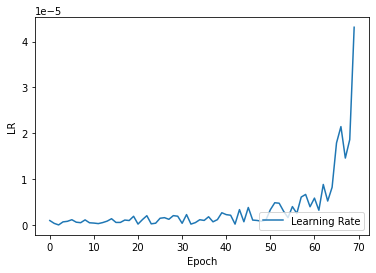

In [ ]:
from random import random,randint,randrange,uniform
lr = []
epoo=70
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  # print(z,(batch_size)/((z+1)**(3/2))/80)
  


  # if (z%2 == 0):
  #   LR = random() * batch_size/10000
  #   lr.append(LR)
  # else:
  LR = random() / (z*10000)
  lr.append(LR)

lr = lr[::-1] 
lord_LR = lr
# print(min(lr))


plt.plot(lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()


# lr = []
# epoo=150
# for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

#   # print(z,(batch_size)/((z+1)**(3/2))/80)
  

#   LR = random() * z/10000
#   # LR=LR/8
#   lr.append(LR)

# plt.plot(lr, label='Learning Rate')
# plt.xlabel('Epoch')
# plt.ylabel('LR')
# plt.legend(loc='lower right')
# plt.show()

**Normal default fit** : LR and Batch Size default    


---
Running them in parts


In [ ]:
# import os

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(datagen.flow(x_train, y_train),
#                     epochs=50,validation_data=(x_test,y_test),
#                     callbacks = cp_callback)

In [ ]:
# acc_1 = []
# val_acc_1 = []
# loss = []
# Vloss = []

# acc_1.append(history.history['accuracy'])
# val_acc_1.append(history.history['val_accuracy'])

# loss.append(history.history['loss'])
# Vloss.append(history.history['val_loss'])

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# model = cifar10_model()

# # Load the previously saved weights
# model.load_weights(checkpoint_path)

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(datagen.flow(x_train, y_train),
#                     epochs=50,validation_data=(x_test,y_test),
#                     callbacks = cp_callback)

In [ ]:
# acc_1.append(history.history['accuracy'])
# val_acc_1.append(history.history['val_accuracy'])

# loss.append(history.history['loss'])
# Vloss.append(history.history['val_loss'])

In [ ]:
# model = cifar10_model()

# # Load the previously saved weights
# model.load_weights(checkpoint_path)

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(datagen.flow(x_train, y_train),
#                     epochs=50,validation_data=(x_test,y_test),
#                     callbacks = cp_callback)

In [ ]:
# acc_1.append(history.history['accuracy'])
# val_acc_1.append(history.history['val_accuracy'])

# loss.append(history.history['loss'])
# Vloss.append(history.history['val_loss'])

In [ ]:
# model = cifar10_model()

# # Load the previously saved weights
# model.load_weights(checkpoint_path)

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(datagen.flow(x_train, y_train),
#                     epochs=50,validation_data=(x_test,y_test),
#                     callbacks = cp_callback)

In [ ]:
# acc_1.append(history.history['accuracy'])
# val_acc_1.append(history.history['val_accuracy'])

# loss.append(history.history['loss'])
# Vloss.append(history.history['val_loss'])

In [ ]:
model = cifar10_model()

# Load the previously saved weights
# model.load_weights(checkpoint_path)

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

history = model.fit(datagen.flow(x_train, y_train),
                    epochs=epoo,
                    validation_data=(x_test,y_test),
                    # callbacks = cp_callback
                    )

Epoch 1/70
1563/1563 [==============================] - 32s 19ms/step - loss: 2.3793 - accuracy: 0.3357 - val_loss: 1.3897 - val_accuracy: 0.5470
Epoch 2/70
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3681 - accuracy: 0.5416 - val_loss: 1.0424 - val_accuracy: 0.6639
Epoch 3/70
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0903 - accuracy: 0.6414 - val_loss: 0.9321 - val_accuracy: 0.7118
Epoch 4/70
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9720 - accuracy: 0.6865 - val_loss: 0.8666 - val_accuracy: 0.7365
Epoch 5/70
1563/1563 [==============================] - 29s 19ms/step - loss: 0.9024 - accuracy: 0.7164 - val_loss: 0.8757 - val_accuracy: 0.7433
Epoch 6/70
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8712 - accuracy: 0.7333 - val_loss: 0.7709 - val_accuracy: 0.7804
Epoch 7/70
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8391 - accuracy: 0.7542 - val_loss: 0.7694 -

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']

In [ ]:
#Save these values in your jsonm
record_Results("acc_1",acc_1)
record_Results("val_acc_1",val_acc_1)


In [ ]:
#Get the saved results
acc_1 = Get_Results("acc_1")["acc_1"]
val_acc_1 = Get_Results("val_acc_1")["val_acc_1"]

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# acc_1.append(history.history['accuracy'])
# val_acc_1.append(history.history['val_accuracy'])

# loss.append(history.history['loss'])
# Vloss.append(history.history['val_loss'])

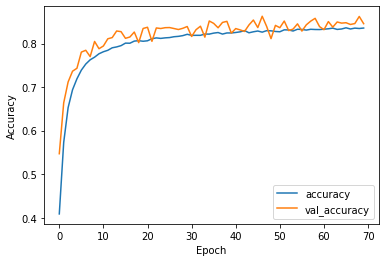

In [ ]:
plt.plot(acc_1, label='accuracy')
plt.plot(val_acc_1, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# plt.plot(loss, label='loss')
# plt.plot(Vloss, label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('loss')
# plt.legend(loc='lower right')
# plt.show()

**LR ∝ BS/Epoch**

In [ ]:
model = cifar10_model()
from random import random
from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []

num = 0

x = 0
# kr = lr
for z,batch_size in zip(range(1,epoo),range(5,10000,5)):

  # if (z%2 == 0):
  #   LR = random() * batch_size/10000
  # # lr.append(LR)
  # else:
  LR = random() / (z*10000)
  # lr.append(LR)

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    global x
    global lord_LR 

    LR=lord_LR[x]
    x+=1
    if(LR>0.009):
      LR = 0.009
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]

  history = model.fit(
            datagen.flow(x_train, y_train), 
            validation_data=(x_test, y_test),
            epochs=epoch,
            batch_size=batch_size,
            callbacks=call
            )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])

  # if(num >= 50 ):
  #   x = input("type anything if you want to continue >  ")
  #   num = 0
  # num += 1




epoch 1, Learning Rate 2.218674794353791e-05, Batch Size  5 

Epoch 00001: LearningRateScheduler reducing learning rate to 4.1654709157187815e-07.
1563/1563 [==============================] - 34s 21ms/step - loss: 4.5950 - accuracy: 0.1077 - val_loss: 2.9416 - val_accuracy: 0.1243


epoch 2, Learning Rate 3.302473535380009e-05, Batch Size  10 

Epoch 00001: LearningRateScheduler reducing learning rate to 1.1699997910551156e-07.
1563/1563 [==============================] - 31s 20ms/step - loss: 4.2887 - accuracy: 0.1147 - val_loss: 2.8986 - val_accuracy: 0.1290


epoch 3, Learning Rate 1.83265876061656e-05, Batch Size  15 

Epoch 00001: LearningRateScheduler reducing learning rate to 2.9188713403418406e-07.
1563/1563 [==============================] - 31s 20ms/step - loss: 4.1709 - accuracy: 0.1167 - val_loss: 2.8074 - val_accuracy: 0.1399


epoch 4, Learning Rate 4.495665459615059e-06, Batch Size  20 

Epoch 00001: LearningRateScheduler reducing learning rate to 7.007907307543857e-08

In [ ]:
acc_2 = acc
val_acc_2 = val_acc

In [ ]:
#Save these values in your jsonm
record_Results("acc_2",acc_2)
record_Results("val_acc_2",val_acc_2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
recorded
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
recorded


In [ ]:
#Get the saved results
acc_2 = Get_Results("acc_2")["acc_2"]
val_acc_2 = Get_Results("val_acc_2")["val_acc_2"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


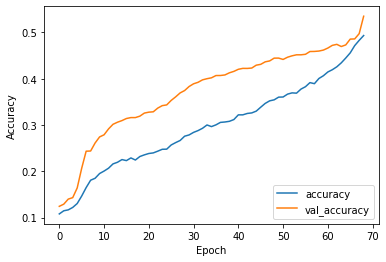

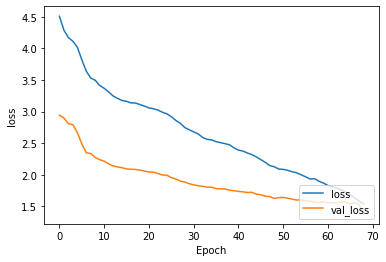

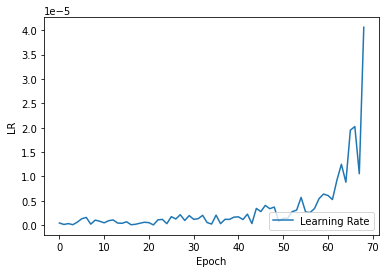

In [ ]:
Plotter(acc,val_acc,loss,val_loss,l_r)

**Keeping batch size constant**

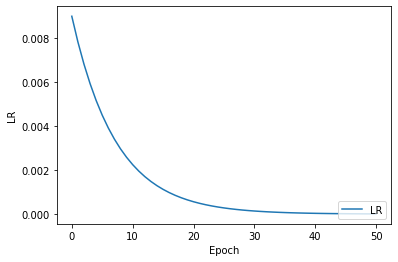

In [ ]:
initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
for i in range(51):
  lr = initial_learning_rate * decay_rate **(i / decay_steps)
  LR.append(lr)
plt.plot(LR, label='LR')
# plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from keras.callbacks import LearningRateScheduler
model = cifar10_model()
# epoo = 1
initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
def setLR(step):
  global LR
  lr = initial_learning_rate * decay_rate **(step / decay_steps)
  LR.append(lr)
  print("called here")
  return lr

call = [ LearningRateScheduler(setLR,verbose=1) ]

history = model.fit(
            datagen.flow(x_train, y_train), 
            validation_data=(x_test, y_test),
            epochs=epoo,
            callbacks=call
            )

Epoch 1/70
called here

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
1563/1563 [==============================] - 31s 19ms/step - loss: 2.8290 - accuracy: 0.3172 - val_loss: 1.4301 - val_accuracy: 0.5417
Epoch 2/70
called here

Epoch 00002: LearningRateScheduler reducing learning rate to 0.007834955069665117.
1563/1563 [==============================] - 30s 19ms/step - loss: 1.5109 - accuracy: 0.5212 - val_loss: 1.5528 - val_accuracy: 0.5751
Epoch 3/70
called here

Epoch 00003: LearningRateScheduler reducing learning rate to 0.006820724549296791.
1563/1563 [==============================] - 29s 19ms/step - loss: 1.4264 - accuracy: 0.5895 - val_loss: 1.2787 - val_accuracy: 0.6602
Epoch 4/70
called here

Epoch 00004: LearningRateScheduler reducing learning rate to 0.005937785598478023.
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3733 - accuracy: 0.6282 - val_loss: 1.2870 - val_accuracy: 0.6733
Epoch 5/70
called here

Epoch 00005: LearningRa

In [ ]:
acc_3 = history.history["accuracy"]
val_acc_3 = history.history["val_accuracy"]

In [ ]:
#Save these values in your jsonm
record_Results("acc_3",acc_3)
record_Results("val_acc_3",val_acc_3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
recorded
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
recorded


In [ ]:
#Get the saved results
acc_3 = Get_Results("acc_3")["acc_3"]
val_acc_3 = Get_Results("val_acc_3")["val_acc_3"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


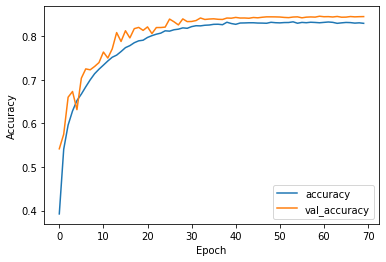

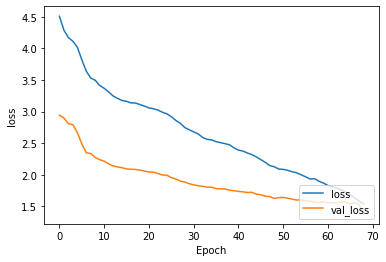

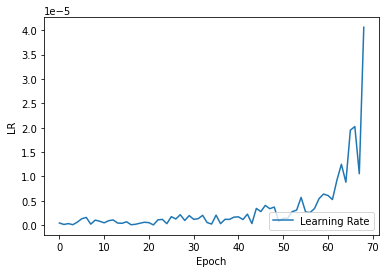

In [ ]:
Plotter(acc_3,val_acc_3,loss,val_loss,l_r)

**LR constant**

In [ ]:
model = cifar10_model()

from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  LR = (batch_size)/(((z+1)**(3/2))*80)
  LR=LR/8

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]

  history = model.fit(
            datagen.flow(x_train, y_train), 
            validation_data=(x_test, y_test),
            epochs=epoch,
            batch_size=batch_size,
            # callbacks=call
            )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



epoch 1, Learning Rate 0.002762135864009951, Batch Size  5 
1563/1563 [==============================] - 34s 21ms/step - loss: 2.3501 - accuracy: 0.3385 - val_loss: 1.4310 - val_accuracy: 0.5492


epoch 2, Learning Rate 0.003007032652029301, Batch Size  10 
1563/1563 [==============================] - 31s 20ms/step - loss: 1.2616 - accuracy: 0.5808 - val_loss: 0.9736 - val_accuracy: 0.6913


epoch 3, Learning Rate 0.0029296875, Batch Size  15 
1563/1563 [==============================] - 31s 20ms/step - loss: 1.0584 - accuracy: 0.6530 - val_loss: 1.1474 - val_accuracy: 0.6653


epoch 4, Learning Rate 0.002795084971874737, Batch Size  20 
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9610 - accuracy: 0.6918 - val_loss: 0.9014 - val_accuracy: 0.7235


epoch 5, Learning Rate 0.0026578664743741078, Batch Size  25 
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9060 - accuracy: 0.7180 - val_loss: 0.8672 - val_accuracy: 0.7412


epoch 6, Learnin

In [ ]:
acc_4 = acc
val_acc_4 = val_acc

In [ ]:
#Save these values in your jsonm
record_Results("acc_4",acc_4)
record_Results("val_acc_4",val_acc_4)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
recorded
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
recorded


In [ ]:
#Get the saved results
acc_4 = Get_Results("acc_4")["acc_4"]
val_acc_4 = Get_Results("val_acc_4")["val_acc_4"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Plotter(acc,val_acc,loss,val_loss,l_r)

**Plotting all of them**

---



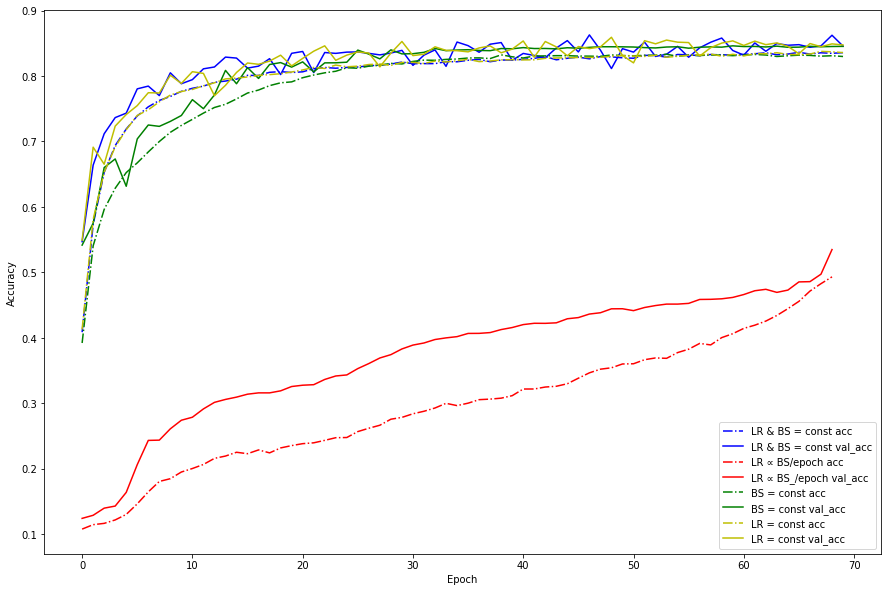

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(acc_1, label='LR & BS = const acc',ls='-.',c='b')
plt.plot(val_acc_1, label = 'LR & BS = const val_acc',c='b')
plt.plot(acc_2, label='LR ∝ BS/epoch acc',ls='-.',c='r')
plt.plot(val_acc_2, label = 'LR ∝ BS_/epoch val_acc',c='r')
plt.plot(acc_3, label='BS = const acc',ls='-.',c='g')
plt.plot(val_acc_3, label = 'BS = const val_acc',c='g')
plt.plot(acc_4, label='LR = const acc',ls='-.',c='y')
plt.plot(val_acc_4, label = 'LR = const val_acc',c='y')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# case4_fashion_acc,case4_fashion_val_acc0

In [ ]:
# 

In [ ]:
acc_1_dif = []
for i in range(len(acc_1)): acc_1_dif.append(acc_1[i] - val_acc_1[i]) 
acc_2_dif = []
for i in range(len(acc_2)): acc_2_dif.append(acc_2[i][0] - val_acc_2[i][0]) 
acc_3_dif = []
for i in range(len(acc_3)): acc_3_dif.append(acc_3[i][0] - val_acc_3[i][0]) 
acc_4_dif = []
for i in range(len(acc_4)): acc_4_dif.append(acc_4[i][0] - val_acc_4[i][0]) 

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(acc_1_dif, label='LR & BS = const acc',ls='-.',c='b')
# plt.plot(val_acc_1, label = 'LR & BS = const val_acc',c='b')
plt.plot(acc_2_dif, label='LR ∝ BS/epoch acc',ls='-.',c='r')
# plt.plot(val_acc_2, label = 'LR ∝ BS_/epoch val_acc',c='r')
plt.plot(acc_3_dif, label='BS = const acc',ls='-.',c='g')
# plt.plot(val_acc_3, label = 'BS = const val_acc',c='g')
plt.plot(acc_4_dif, label='LR = const acc',ls='-.',c='y')
# plt.plot(val_acc_4, label = 'LR = const val_acc',c='y')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
!pip install youtube-dl

In [ ]:
!youtube-dl "https://www.youtube.com/watch?v=PXDQFBmg1GI&ab_channel=%C3%87erkesTV"